# Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Basic libraries
#
import time
import pickle
import pandas as pd
import numpy as np


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization library
#
import matplotlib.pyplot as plt


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Neural Prophet library
#
from neuralprophet import NeuralProphet

# Import data

In [3]:
# Start timer
#
start = time.time()

# Load data
#
df = pd.read_csv('Data/Temperature.csv')

print('[INFO] Data imported')
print('[INFO] Time: %.2f seconds' % (time.time() - start))

[INFO] Data imported
[INFO] Time: 0.01 seconds


## Preprocess

In [4]:
df = df[ ['Date', 'Temperature'] ]
df = df.rename(columns = {'Date':'ds', 'Temperature':'y'})

df['ds'] = df['ds'].astype('datetime64')
df.set_index('ds', inplace=True)

In [5]:
df.head(3)

,y
ds,
2015-02-11 14:48:00,21.7600
2015-02-11 14:49:00,21.7900
2015-02-11 14:50:00,21.7675


# Training/Testing sets

In [6]:
# Create training/testing dfsets
#
idx = int( df.shape[0] * 0.9)

df_train = df.iloc[ :idx ]
df_test  = df.iloc[ idx: ]


Horizon = df_test.shape[0]

print('Horizon: ', Horizon)

Horizon:  976


## Visualization

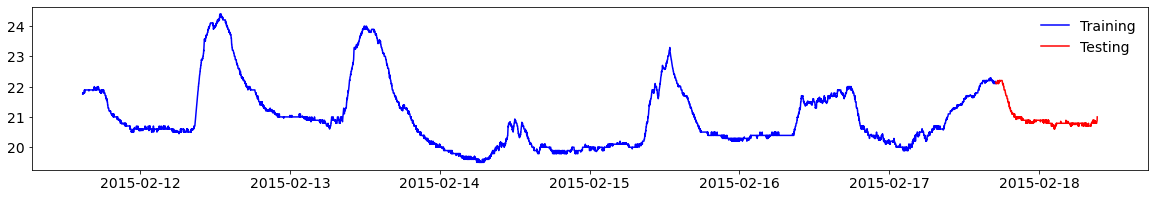

In [7]:
plt.figure( figsize=(20, 3) );

plt.plot(df_train, color='b')
plt.plot(df_test,  color='r')

plt.legend(['Training', 'Testing'], fontsize=14, frameon=False);
plt.xticks(size=14);
plt.yticks(size=14);

# Neural Prophet

In [8]:
model = NeuralProphet(
    growth = "linear",   # Determine trend types: 'linear', 'discontinuous', 'off'
    changepoints=None, # list of dates that may include change points (None -> automatic )
    n_changepoints=5,
    changepoints_range=0.8,
    trend_reg=0,
    trend_reg_threshold=False,
    yearly_seasonality="auto",
    weekly_seasonality="auto",
    daily_seasonality="auto",
    seasonality_mode="additive",
    seasonality_reg=0,
    n_forecasts=1,
    n_lags=0,
    num_hidden_layers=0,
    d_hidden=None,     # Dimension of hidden layers of AR-Net
    ar_sparsity=None,  # Sparcity in the AR coefficients
    learning_rate=None,
    epochs=40,
    loss_func="Huber",
    normalize="auto",  # Type of normalization ('minmax', 'standardize', 'soft', 'off')
    impute_missing=True,
)

## Training

In [9]:
metrics = model.fit(df_train.reset_index(), validate_each_epoch=True, freq='1min', epochs=1000)

INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32


  0%|          | 0/292 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.98E-02, min: 8.47E-01
INFO - (NP.utils_torch.lr_range_test) - learning rate range test selected lr: 2.78E-01
Epoch[1000/1000]: 100%|██████████| 1000/1000 [07:36<00:00,  2.19it/s, SmoothL1Loss=0.00422, MAE=0.295, MSE=0.154, RegLoss=0, MAE_val=0.683, MSE_val=0.702, SmoothL1Loss_val=0.0193]


## Training performance

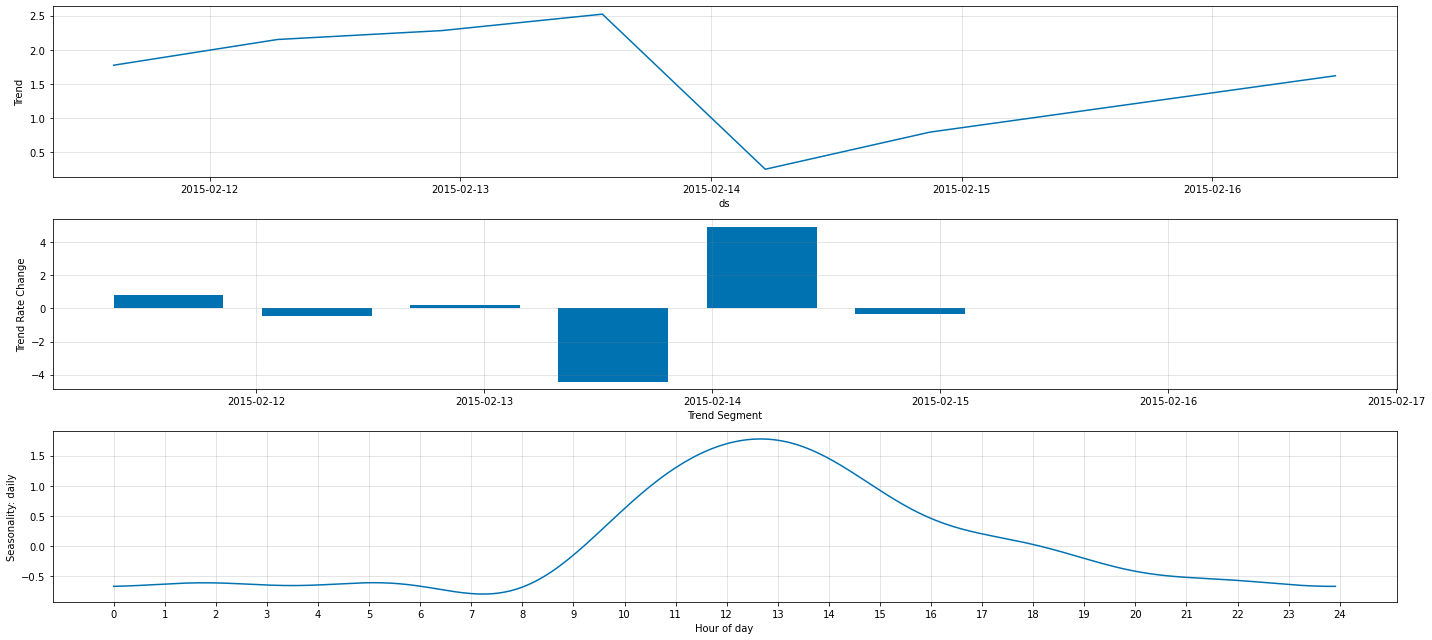

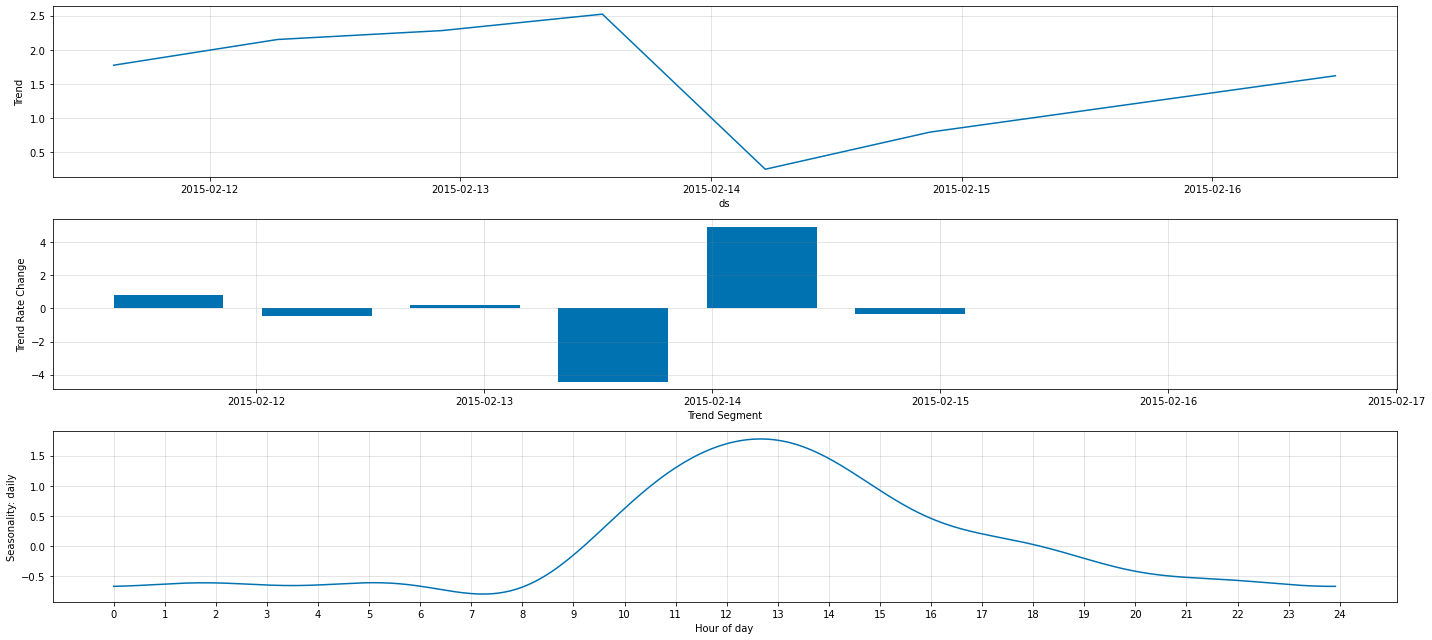

In [45]:
# Plot model's parameters
#
model.plot_parameters( figsize=(20, 9))

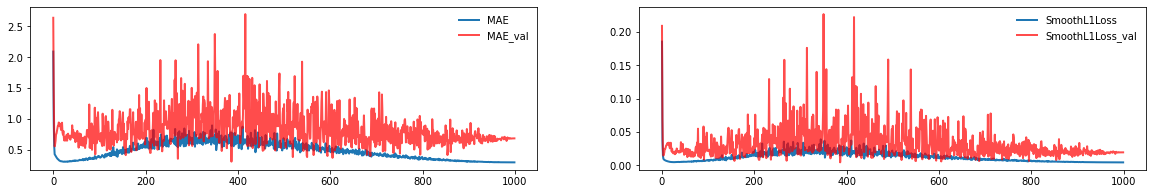

In [40]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 3))

ax[0].plot(metrics["MAE"],     color = 'tab:blue', linewidth=2)  
ax[0].plot(metrics["MAE_val"], color = 'red',      linewidth=2, alpha=0.7)

ax[1].plot(metrics["SmoothL1Loss"],     color = 'tab:blue', linewidth=2)  
ax[1].plot(metrics["SmoothL1Loss_val"], color = 'red',      linewidth=2, alpha=0.7)


ax[0].legend(['MAE',          'MAE_val'],          frameon=False)
ax[1].legend(['SmoothL1Loss', 'SmoothL1Loss_val'], frameon=False)

# Prediction

In [20]:
# Prediction of future values
#
forecast = model.make_future_dataframe(df_train.reset_index(), periods=Horizon)
forecast = model.predict(future)


# Include real values
#
forecast['y'] = df_test['y'].values

# Calculate residuals
#
forecast['residual1'] = forecast['y'] - forecast['yhat1']

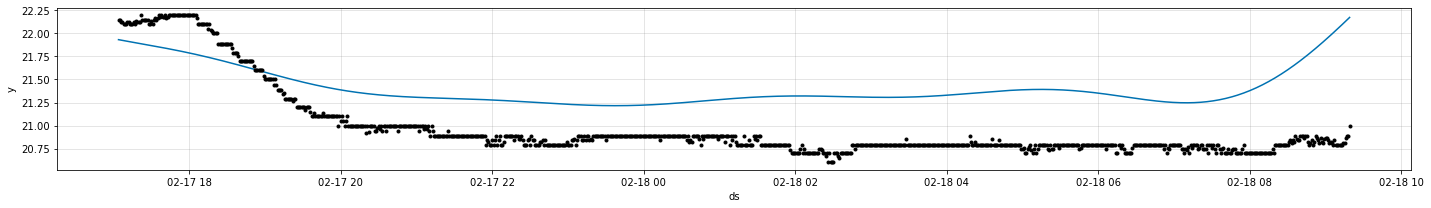

In [28]:
plot1 = model.plot(forecast, figsize=(20, 3))

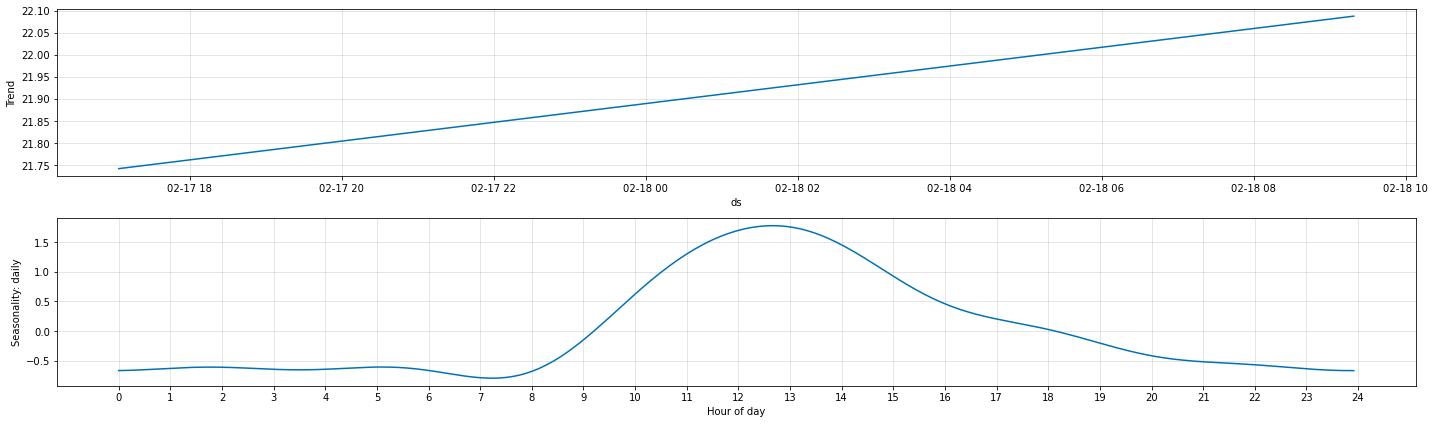

In [27]:
plot2 = model.plot_components(forecast, figsize=(20, 6))

## Save model

In [47]:
with open('Neural_Prophet_model.pkl', "wb") as f:
    pickle.dump(model, f)
    
# # Load model
# #
# with open('Neural_Prophet_model.pkl', "rb") as f:
#     m = pickle.load(f)